In [1]:
import os
import gnssrefl.gps as g
import gnssrefl.rinex2snr as rnx
import gnssrefl.quickLook_function as quick
import gnssrefl.gnssir as guts
import json
import pandas as pd 
import numpy as np
import check_parameters
import requests
import matplotlib.pyplot as plt

from csv import reader
import re
from datetime import datetime
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set_theme(style="whitegrid");


g.check_environ_variables()

%matplotlib inline

ModuleNotFoundError: No module named 'check_parameters'

### Ross Ice Shelf, Antarctica

**Station Name:**  lorg

**Location:**  Lorne, Antarctica

**Archive:**  [UNAVCO](http://www.unavco.org)

**DOI:**  [https://doi.org/10.7283/ACF6-YT23](https://doi.org/10.7283/ACF6-YT23)

**Ellipsoidal Coordinates:**

- Latitude:  -78.18365
- Longitude: 170.03361
- Height:  	-7.778 m

[Station Page at UNAVCO](https://www.unavco.org/instrumentation/networks/status/nota/overview/lorg)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/LORG.sta)

[Google Maps Link](https://goo.gl/maps/bSAuLXLLMmzWqPdW9) 

<img src="https://gnss-reflections.org/static/images/LORG.jpg" width="500">



### Data Summary

Station lorg is on the Ross Ice Shelf, Antarctica.
The site is a largely featureless ice plain with no obstructions (see photo above). 
The site was installed on November 27, 2018 and decommissioned and removed on November 15, 2019. 
It recorded only GPS frequencies during its operation. 

LORG is an example station on the [GNSS-IR web app.](https://gnss-reflections.org/api?example=lorg) 

There are no significant topographic features near the station, so it is recommended to use default values 
for the elevation mask. An azimuth mask is not required.

If you are curious about the position time series for the antenna, you can use *download_unr lorg* for more information.



In [3]:
%%html
<iframe src="https://gnss-reflections.org/api?example=lorg" width="1000" height="900"></iframe>

## Take a look at the Data

First make a SNR file.

In [4]:
station = 'lorg'
year = 2019 
doy = 205

lat = -78.1836
long = 170.0336
height = -7.722

In [ ]:
# Can view the parameters here
#check_parameters.rinex2snr?

In [5]:
args = check_parameters.rinex2snr(station,year,doy, translator='hybrid')
rnx.run_rinex2snr(**args)

SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2050.19.snr66




Use **quickLook** to produce a periodogram similar to the one in the web app [(For details on quickLook output)](../../docs/quickLook_desc.md). quickLook is set to use the L1 frequency by default:

In [6]:
# making a plotting function for the quicklook function
def quicklook_results(args, values):
    freq = {1:'L1', 20: 'L2C', 5:'L5'}
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    quadrants = ['NW', 'NE', 'SW', 'SE']
    axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    for i, quadrant in enumerate(quadrants):
        satellites = values[quadrant].keys()
        fail_satellites = values[f'f{quadrant}'].keys()

        for failsat in fail_satellites:
            axes[i].plot(values[f'f{quadrant}'][failsat][0], values[f'f{quadrant}'][failsat][1], color='lightgrey') 
        for sat in satellites:
            axes[i].plot(values[quadrant][sat][0], values[quadrant][sat][1])

    ax[0,0].set_title('Northwest', size=14)
    ax[0,1].set_title('Northeast',size=14)
    ax[1,0].set_title('Southwest', size=14)
    ax[1,1].set_title('Southeast', size=14)

    for ax in axes:
        ax.set_xlabel('reflector height (m)', size=14)
        ax.set_ylabel('volts/volts', size=14)
        ax.grid()
    
    fig.suptitle(f'GNSS Station {args["station"].upper()}, {args["year"]} doy {args["doy"]}, freq {freq[args["f"]]}, elevation angles {args["e1"]}-{args["e2"]} \n', size=16)
    fig.tight_layout()
    plt.show()
    
    
def quicklook_metrics(args, values):
#     fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
    quadrants = ['NW', 'NE', 'SW', 'SE']
    
    # re-organizing the data in a plotting friendly format
    success_data = {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise':[], 'Amplitude': []}
    fail_data =  {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise': [], 'Amplitude': []}
    
    for i, quadrant in enumerate(quadrants):
        for j in values[quadrant].keys():
            success_data['Azimuth'].append(datakeys[quadrant][j][0])
            success_data['Reflector Height'].append(datakeys[quadrant][j][1])
            success_data['Peak to Noise'].append(datakeys[quadrant][j][5])
            success_data['Amplitude'].append(datakeys[quadrant][j][4])
        for k in values[f'f{quadrant}'].keys():
            fail_data['Azimuth'].append(datakeys[f'f{quadrant}'][k][0])
            fail_data['Reflector Height'].append(datakeys[f'f{quadrant}'][k][1])
            fail_data['Peak to Noise'].append(datakeys[f'f{quadrant}'][k][5])
            fail_data['Amplitude'].append(datakeys[f'f{quadrant}'][k][4])

    return pd.DataFrame(success_data), pd.DataFrame(fail_data)

minimum elevation angle (degrees) for this dataset:  0.0053


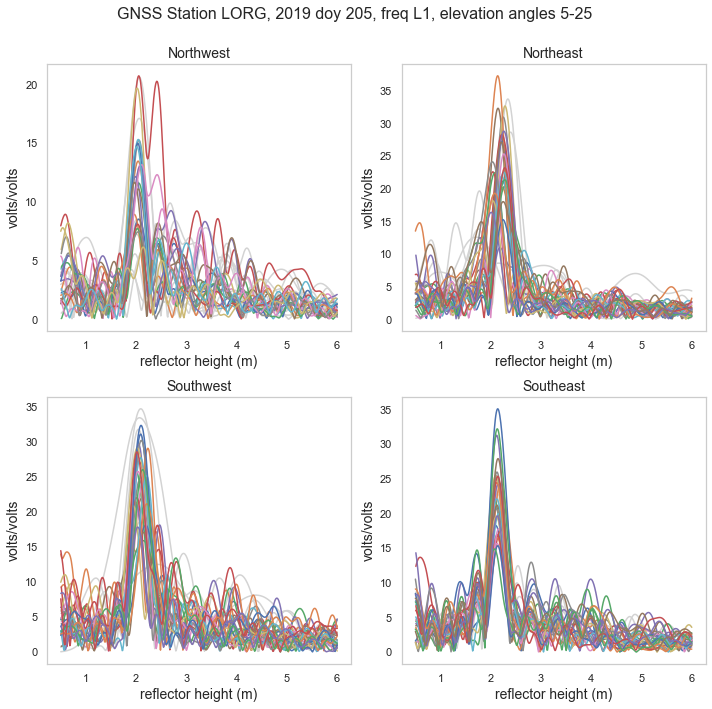

In [7]:
args = check_parameters.quicklook(station, year, doy=doy)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

Compare the periodograms for other frequencies: L2C and L5. They should be similar to the L1 periodogram, except that there
will be fewer satellite traces because only GPS satellites launched after 2005
broadcast L2C and only satellites after 2010 broadcast L5.
The northwest qudarant is the noisiest and one could certainly try to improve the results by restricting some azimuths there.
This is for L2C:

minimum elevation angle (degrees) for this dataset:  0.0053


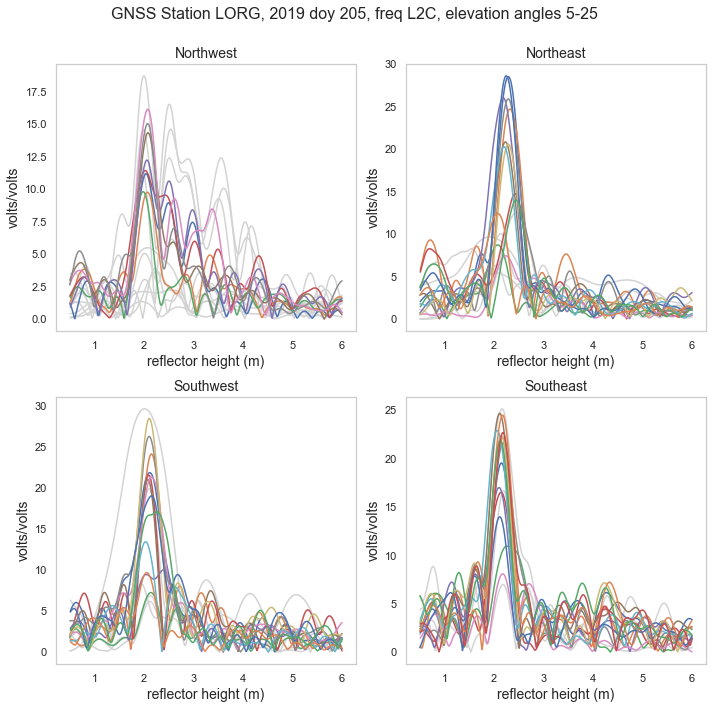

In [8]:
args = check_parameters.quicklook(station, year, doy=doy, f=20)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

This is for L5:

minimum elevation angle (degrees) for this dataset:  0.0053


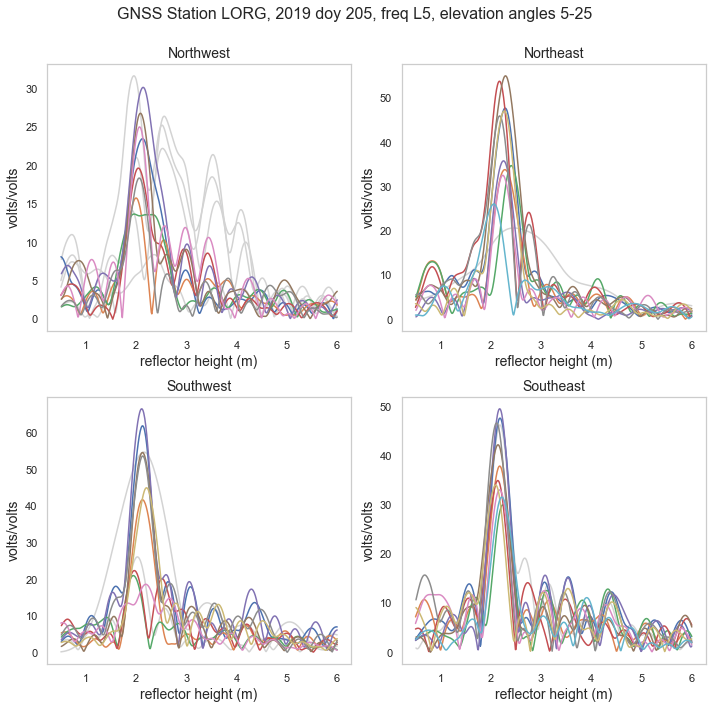

In [10]:
args = check_parameters.quicklook(station, year, doy=doy, f=5)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

### Analyze the Data
Now prepare to analyze the data using **gnssir**.  First you need to create a set of analysis instructions.
The default settings only need the station name, latitude, longitude, and ellipsoidal height.

In [11]:
# Here we can see what parameters are available and what the defaults are:
#check_parameters.make_json?

In [12]:
# we saved the lat, long, and height earlier
check_parameters.make_json(station, lat, long, height)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/lorg.json


In [14]:
# This is the json file that was created
json_file = 'input/lorg.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)

os.remove(json_file)
with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'lorg',
 'lat': -78.1836,
 'lon': 170.0336,
 'ht': -7.722,
 'minH': 0.5,
 'maxH': 6,
 'e1': 5,
 'e2': 25,
 'NReg': [0.5, 6],
 'PkNoise': 2.7,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [0, 90, 90, 180, 180, 270, 270, 360],
 'freqs': [1, 20, 5],
 'reqAmp': [6.0, 6.0, 6.0],
 'refraction': True,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'lorg_lsp.png',
 'delTmax': 75}

Next make some snr files for a time span of about eight months. Restrict the search to the UNAVCO archive to make the
code run faster (otherwise it will check three other archives as well). The resulting SNR files will be stored in $REFL_CODE/2019/snr/lorg.

In [15]:
#check_parameters.rinex2snr?

In [16]:
args = check_parameters.rinex2snr(station, year=2019, doy=1, doy_end=233, archive='unavco', translator='fortran')
rnx.run_rinex2snr(**args)

Will seek RINEX file  lorg  year: 2019  doy: 1  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0010.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 2  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0020.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 3  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0030.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 4  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0040.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 5  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0050.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 6  translate with  f



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0450.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 46  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0460.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 47  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0470.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 48  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0480.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 49  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0490.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 50  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0890.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 90  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0900.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 91  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0910.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 92  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0920.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 93  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0930.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 94  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1330.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 134  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1340.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 135  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1350.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 136  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1360.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 137  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1370.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 138  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1770.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 178  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1780.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 179  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1790.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 180  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1800.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 181  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1810.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 182  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2220.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 223  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2230.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 224  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2240.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 225  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2250.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 226  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2260.19.snr66
Will seek RINEX file  lorg  year: 2019  doy: 227  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr

Run **gnssir** for all the SNR files from **rinex2snr**.

In [ ]:
#check_parameters.gnssir?

In [17]:
doy = 1
doy_end=233
args = check_parameters.gnssir(station, year, doy=doy, doy_end=doy_end, screenstats=False)

year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

refraction file exists
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//035.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0350.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//036.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0360.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//037.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0370.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//038.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0380.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//039.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//074.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0740.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//075.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0750.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//076.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0760.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//077.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg0770.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//078.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//113.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1130.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//114.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1140.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//115.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1150.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//116.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1160.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//117.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//152.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1520.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//153.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1530.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//154.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1540.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//155.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1550.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//156.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//191.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1910.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//192.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1920.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//193.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1930.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//194.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg1940.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//195.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//230.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2300.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//231.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2310.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//232.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2320.19.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/results/lorg//233.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2019/snr/lorg/lorg2330.19.snr66


The default does not send any plots to the screen. If you do want to see them, set -plt True:

In [ ]:
doy = 1
args = check_parameters.gnssir(station, year, doy=1, plt=True, screenstats=False)
year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
print(doy_list)
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

Unlike **quickLook**, **gnssir** plots the periodograms for each frequency with no quadrants. To see the next frequency, close the current plot.

These results can be cleaned up by eliminating various azimuths and requiring stronger peaks in the periodograms in the json file, but for now just use defaults.
The reflector heights are stored in $REFL_CODE/2019/results/lorg.

The **daily_avg** command will calculate the daily average reflector height from the daily output files. To minimize outliers in these daily averages, a median filter is set to 0.25 meters and the required minimum number of daily satellite tracks is set to 50.

In [ ]:
check_parameters.daily_avg?

In [ ]:
check_parameters.daily_avg(station, medfilter=.25, ReqTracks=50)

This shows the range of reflector heights each day, with each day represented by a different color.

There are also optional inputs for saving a text file of the daily averages. 
The plot is stored at $REFL_CODE/Files/lorg_RH.png 
This is not yet perfect - there are some outliers which have been **circled in red**. 
But it is an excellent example of how easy it is to use the default gnssrefl code to estimate snow accumulation in Antarctica.

In this exercise L1, L2C, and L5 signals were used (i.e. only GPS data). The reflector heights give information 
about snow accumulation at lorg. Notice that when reflector heights are plotted, the y-axis is reversed so that the reflector height gets smaller as the snow layer increases and the distance between the antenna and snow surface decreases.  